# Engineer feature variables

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from ast import literal_eval
import missingno as msno
from scipy.stats import linregress
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


### Import dataset

In [2]:
with open('processed_data/clean_build.pkl', 'rb') as filename:  
    clean_data = pickle.load(filename)

/var/folders/_q/50__mrnj2zv6hb8crhk3q46m0000gn/T/ipykernel_97425/3513447208.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  clean_data = pickle.load(filename)


In [3]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6822 entries, 0 to 6821
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     6822 non-null   object 
 1   budget                    6822 non-null   float64
 2   worldwide_boxoffice       6822 non-null   float64
 3   domestic_boxoffice        6822 non-null   float64
 4   clean_title               6822 non-null   object 
 5   imdb_id                   6812 non-null   object 
 6   release_date              6766 non-null   object 
 7   year                      6766 non-null   float64
 8   top_director              6822 non-null   object 
 9   top_cast                  6822 non-null   object 
 10  rating                    6822 non-null   float64
 11  runtime                   6822 non-null   float64
 12  original_language         6822 non-null   object 
 13  enrichment_source         6822 non-null   object 
 14  boxoffic

#### Define functions for feature engineering

In [4]:
#function to adjust for inflation, input the number and year and it will say the value adjusted for inflation to 2025
from scipy.stats import gmean

def adjust_inflation(num, year):
    diff = 2025 - year
    final_num = num * (1.0325)**diff
    return final_num
    
# def get_entry(x, entry = 'name', rank = 0):
#     if isinstance(x, list):
#         entries = [i[entry] for i in x]
#         # keep only top 3 entries
#         if len(entries) > rank:
#             out = entries[rank]
#         else:
#             out = np.nan
#         return out

#     return np.nan

def get_entry(x, rank = 0):
    if isinstance(x, list) and len(x) > rank:
        out = x[rank]
    else:
        out = np.nan
    return out

    return np.nan

def indiv_value_before_year(x, variable = "actor_id_1", category = "top_cast", value_field = "wroi", period = 5, data = clean_data):
    # Computes average, lagged "value" of a single entity (actor, director, production company, genre)
    delay = 2
    use_data = data.loc[(data['year'] < x['year'] - delay)*(data['year'] >= (x['year'] - period - delay))]
    if len(use_data) > 0 and isinstance(x[variable], str):
        mask = np.array([x[variable] in entry for entry in use_data[category]]) #if variable != 'director_id' else np.array([x[variable] == entry for entry in use_data[category]])
        if np.sum(mask) > 0.0:
            vallist = use_data[mask]
            # Compute geometric mean
            value = np.log(gmean(vallist[value_field].values))
        else:
            value = 0.0
    else:
        value = 0.0
    return value

def role_value_before_year(x, variables = ["actor_id_1", "actor_id_2", "actor_id_3"], category = "top_cast", value_field = "wroi", period = 5, data = clean_data):
    # Computes average, lagged "value" of a group
    delay = 2
    use_data = data.loc[(data['year'] < x['year'] - delay)*(data['year'] >= (x['year'] - period - delay))]
    if len(use_data):
        mask = np.amax(np.array([[x[variable] in entry for entry in use_data[category]] if isinstance(x[variable], str) else len(use_data)*[False] for variable in variables]), axis = 0)
        if np.sum(mask) > 0.0:
            vallist = use_data[mask]
            # Compute geometric mean
            value = np.log(gmean(vallist[value_field].values))
        else:
            value = 0.0
    else:
        value = 0.0
    return value

def appearances_before_year(x, variable = "actor_id_1", category = "top_cast", value_field = "wroi", period = 5, data = clean_data):
    delay = 2
    use_data = data.loc[(data['year'] < x['year'] - delay)*(data['year'] >= (x['year'] - period - delay))]
    if len(use_data) > 0 and isinstance(x[variable], str):
        mask = np.array([x[variable] in entry for entry in use_data[category]])
        if np.sum(mask) > 0.0:
            vallist = use_data[mask]
            # Count occurence of actor in the five year period
            value = len(vallist[value_field].values)
        else:
            value = 0.0
    else:
        value = 0.0
    return value

def get_movie_similarity(x, similarity_variable = 'movie_overview', value_field = "wroi", period = 5, data = clean_data):
    delay = 2
    # Define a TF-IDF vectorizer object, and remove all english stop words
    tfidf = TfidfVectorizer(stop_words = "english")
    
    # Subset to data from prior years including the current movie
    use_data = data.loc[(data['year'] < x['year'] - delay)*(data['year'] >= (x['year'] - period - delay)) + (data.title == x.title)*(data.year == x.year)].reset_index()
    use_data[similarity_variable] = use_data[similarity_variable].fillna('')
    idx = use_data.loc[(use_data.title == x.title)*(use_data.year == x.year)].index.item()
    # Construct the required matrix
    tfidf_matrix = tfidf.fit_transform(use_data[similarity_variable])

    # compute cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get pairwise similarity scores relative to current movie, and select top 3 most similar movies
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse= True)
    sim_scores = sim_scores[1:6]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]
    similar_movies_value = use_data[value_field].iloc[movie_indices].values

    # Compute average value
    if len(similar_movies_value) > 1:
        out = np.log(gmean(similar_movies_value))
    elif len(similar_movies_value) == 1:
        out = np.log(np.mean(similar_movies_value))
    else:
        out = 0.0

    return out

In [5]:
# Create adjusted revenue variables
clean_data['year'] = pd.to_numeric(clean_data['year'])
clean_data.loc[:, 'adjusted_worldwide_boxoffice'] = adjust_inflation(clean_data['worldwide_boxoffice'], clean_data['year'])
clean_data.loc[:, 'adjusted_domestic_boxoffice'] = adjust_inflation(clean_data['domestic_boxoffice'], clean_data['year'])
clean_data.loc[:, 'adjusted_budget'] = adjust_inflation(clean_data['budget'], clean_data['year'])
clean_data.loc[:, 'log_adjusted_budget'] = np.log(adjust_inflation(clean_data['budget'], clean_data['year']))
clean_data.loc[:,'wroi'] = clean_data['adjusted_worldwide_boxoffice']/clean_data['adjusted_budget']
clean_data.loc[:,'droi'] = clean_data['adjusted_domestic_boxoffice']/clean_data['adjusted_budget']
clean_data.loc[:,'log_wroi'] = np.log(clean_data['wroi'])
clean_data.loc[:,'log_droi'] = np.log(clean_data['droi'])

# Split string variables
for i in np.arange(0,3):
    clean_data.loc[:, 'director_name_'+str(i + 1)] = clean_data['top_director'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'director_id_'+str(i + 1)] = clean_data['top_director_id'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'actor_name_'+str(i + 1)] = clean_data['top_cast'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'actor_id_'+str(i + 1)] = clean_data['top_cast_id'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'genre_name_'+str(i + 1)] = clean_data['genres_list'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'production_country_'+str(i + 1)] = clean_data['top_production_countries'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'production_company_'+str(i + 1)] = clean_data['top_production_companies'].apply(literal_eval).apply(get_entry, args = ([i]))

# Praneed insert code for other features here #
clean_data.loc[:,'is_language_english'] = (clean_data['original_language'] == "English")*1
clean_data.loc[:,'is_production_usa'] = 1*((clean_data['production_country_1'] == "United States of America") + (clean_data['production_country_2'] == "United States of America") + (clean_data['production_country_3'] == "United States of America") > 0) 
df= clean_data.copy()
for col in ['adjusted_budget', 'adjusted_domestic_boxoffice', 'adjusted_worldwide_boxoffice']:
        if col in df.columns and df[col].notna().any():
            Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            IQR = Q3 - Q1
            df[f'{col}_outlier'] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).astype(int)

conditions = [
            (df['wroi'] < 0), 
            (df['wroi'] < 1), 
            (df['wroi'] < 2), 
            (df['wroi'] < 5), 
            (df['wroi'] >= 5)
        ]
values = ['Flop', 'Break Even', 'Modest Hit', 'Hit', 'Blockbuster']
df['adjusted_success'] = np.select(conditions, values, default='Unknown')

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### More features to qunatify actors and directors(Experimentation for predictive power)

In [6]:
def calculate_commercial_critical_balance(df, entity_id, entity_type='director'):

    prefix = 'director' if entity_type == 'director' else 'actor'
    entity_films = df[df[f'{prefix}_id_1'] == entity_id]
    
    if len(entity_films) == 0:
        return None
    avg_rating = entity_films['rating'].mean() 
    avg_wroi = entity_films['wroi'].mean()
    norm_rating = avg_rating / df['rating'].max()
    norm_wroi = avg_wroi / df['wroi'].max()
    
    cc_ratio = float('inf') if norm_wroi <= 0 else norm_rating / norm_wroi

    return {
        'cc_ratio': cc_ratio,
        'avg_rating': avg_rating,
        'avg_wroi': avg_wroi,
        'film_count': len(entity_films)
    }


def calculate_budget_efficiency(df, entity_id, entity_type='director'):
    prefix = 'director' if entity_type == 'director' else 'actor'
    entity_films = df[df[f'{prefix}_id_1'] == entity_id]
    
    valid_films = entity_films[entity_films['adjusted_budget'] > 0]
    
    if len(valid_films) == 0:
        return None
    efficiency = valid_films['adjusted_worldwide_boxoffice'].sum() / valid_films['adjusted_budget'].sum()
    
    return {
        'budget_efficiency': efficiency,
        'total_budget': valid_films['adjusted_budget'].sum(),
        'total_boxoffice': valid_films['adjusted_worldwide_boxoffice'].sum(),
        'film_count': len(valid_films)
    }


In [7]:
def build_talent_profiles(df):
    director_ids = set(df['director_id_1'].dropna().unique())
    actor_ids = set(df['actor_id_1'].dropna().unique())
    
    # profile dictionaries
    director_profiles = {}
    for director_id in director_ids:
        # Skip if ID is NaN
        if pd.isna(director_id):
            continue

        director_name = df[df['director_id_1'] == director_id]['director_name_1'].iloc[0]
        cc_balance = calculate_commercial_critical_balance(df, director_id, 'director')
        budget_eff = calculate_budget_efficiency(df, director_id, 'director')

        # store in profile dictionary 
        if cc_balance and budget_eff:
            director_profiles[director_id] = {
                'director_id': director_id,
                'director_name': director_name,
                'cc_ratio': cc_balance['cc_ratio'],
                'budget_efficiency': budget_eff['budget_efficiency'],
                'film_count': cc_balance['film_count']
            }
    
    #  actors
    actor_profiles = {}
    for actor_id in actor_ids:
        if pd.isna(actor_id):
            continue
            
        actor_name = df[df['actor_id_1'] == actor_id]['actor_name_1'].iloc[0]
        
        cc_balance = calculate_commercial_critical_balance(df, actor_id, 'actor')
        budget_eff = calculate_budget_efficiency(df, actor_id, 'actor')
        
        if cc_balance and budget_eff:
            actor_profiles[actor_id] = {
                'actor_id': actor_id,
                'actor_name': actor_name,
                'cc_ratio': cc_balance['cc_ratio'],
                'budget_efficiency': budget_eff['budget_efficiency'],
                'film_count': cc_balance['film_count']
            }
    
    director_df = pd.DataFrame.from_dict(director_profiles, orient='index')
    actor_df = pd.DataFrame.from_dict(actor_profiles, orient='index')
    
    return director_df, actor_df

In [8]:
def enhance_dataset_with_profiles(df, director_profiles, actor_profiles):
    enhanced_df = df.copy()
    
    for i in range(1, 4):  
        if f'director_id_{i}' in enhanced_df.columns:
            # mapping dictionaries for each metric
            cc_map = director_profiles.set_index('director_id')['cc_ratio'].to_dict()
            efficiency_map = director_profiles.set_index('director_id')['budget_efficiency'].to_dict()
            
            enhanced_df[f'director_{i}_cc_ratio'] = enhanced_df[f'director_id_{i}'].map(cc_map)
            enhanced_df[f'director_{i}_budget_efficiency'] = enhanced_df[f'director_id_{i}'].map(efficiency_map)
    
    # actor metrics
    for i in range(1, 4):  
        if f'actor_id_{i}' in enhanced_df.columns:
            cc_map = actor_profiles.set_index('actor_id')['cc_ratio'].to_dict()
            efficiency_map = actor_profiles.set_index('actor_id')['budget_efficiency'].to_dict()
            
            enhanced_df[f'actor_{i}_cc_ratio'] = enhanced_df[f'actor_id_{i}'].map(cc_map)
            enhanced_df[f'actor_{i}_budget_efficiency'] = enhanced_df[f'actor_id_{i}'].map(efficiency_map)
    
    return enhanced_df

In [9]:
director_profiles, actor_profiles = build_talent_profiles(df)
df = enhance_dataset_with_profiles(df, director_profiles, actor_profiles)

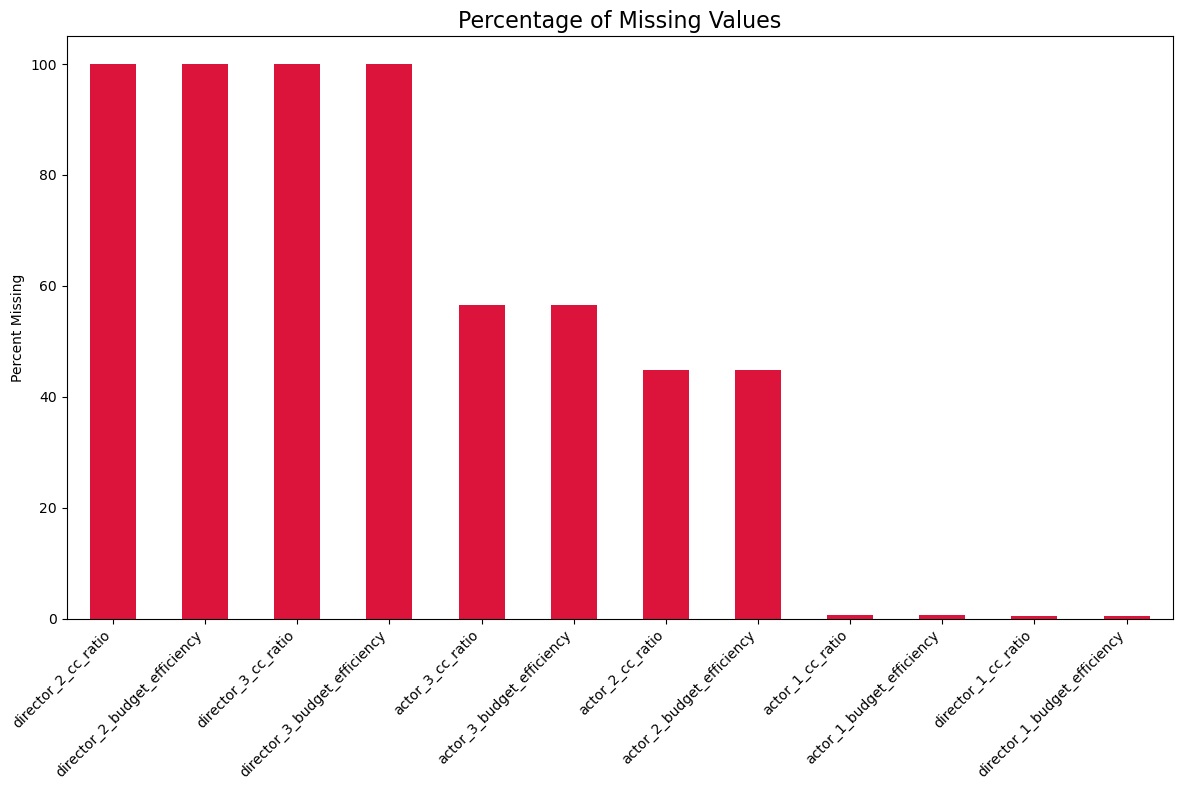

In [10]:
director_vars = [f'director_{i}_{m}' for i in range(1,4) for m in ['cc_ratio', 'budget_efficiency']]
actor_vars = [f'actor_{i}_{m}' for i in range(1,4) for m in ['cc_ratio', 'budget_efficiency']]
talent_vars = director_vars + actor_vars


missing_pct = df[talent_vars].isna().mean().sort_values(ascending=False) * 100
plt.figure(figsize=(12, 8))
missing_pct.plot(kind='bar', color='crimson')
plt.title('Percentage of Missing Values', fontsize=16)
plt.ylabel('Percent Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
columns_to_drop = ['director_2_cc_ratio', 'director_2_budget_efficiency','director_3_cc_ratio', 'director_3_budget_efficiency','actor_2_cc_ratio', 'actor_2_budget_efficiency','actor_3_cc_ratio', 'actor_3_budget_efficiency']
df = df.drop(columns=columns_to_drop)

### To qunatify production companies (only to experiment)

In [12]:
def add_production_efficiency_features(df):

    company_efficiency = {}
    all_companies = set()
    for col in ['production_company_1', 'production_company_2', 'production_company_3']:
        if col in df.columns:
            all_companies.update(df[col].dropna().unique())
    if 'Unknown' in all_companies:
        all_companies.remove('Unknown')
    
    for company in all_companies:
        company_mask = (df['production_company_1'] == company) | \
                       (df['production_company_2'] == company) | \
                       (df['production_company_3'] == company)
        company_movies = df[company_mask]
        
        if len(company_movies) >= 3:
            budgets = company_movies['adjusted_budget'].values
            revenues = company_movies['adjusted_worldwide_boxoffice'].values
            
            try:
               
                slope, _, r_value, _, _ = linregress(budgets, revenues)
                
                # budget segmentation
                budget_median = company_movies['adjusted_budget'].median()
                low_movies = company_movies[company_movies['adjusted_budget'] < budget_median]
                high_movies = company_movies[company_movies['adjusted_budget'] >= budget_median]
                
               
                low_success = low_movies['adjusted_success'].isin(['Hit', 'Blockbuster']).mean() if len(low_movies) > 0 else np.nan
                high_success = high_movies['adjusted_success'].isin(['Hit', 'Blockbuster']).mean() if len(high_movies) > 0 else np.nan
                
                # Store all metrics
                company_efficiency[company] = {
                    'revenue_ratio': revenues.sum() / budgets.sum(),
                    'slope': slope,
                    'predictability': r_value**2,
                    'avg_roi': company_movies['wroi'].mean(),
                    'low_roi': low_movies['wroi'].median() if len(low_movies) > 0 else np.nan,
                    'high_roi': high_movies['wroi'].median() if len(high_movies) > 0 else np.nan,
                    'low_success': low_success,
                    'high_success': high_success,
                    'risk_ratio': company_movies['wroi'].std() / company_movies['wroi'].mean() 
                                  if company_movies['wroi'].mean() != 0 else np.nan,
                    'movie_count': len(company_movies)
                }
            except:
                
                company_efficiency[company] = {
                    'revenue_ratio': revenues.sum() / budgets.sum() if budgets.sum() > 0 else np.nan,
                    'slope': np.nan, 
                    'predictability': np.nan,
                    'avg_roi': company_movies['wroi'].mean(),
                    'low_roi': np.nan, 
                    'high_roi': np.nan,
                    'low_success': np.nan, 
                    'high_success': np.nan,
                    'risk_ratio': np.nan,
                    'movie_count': len(company_movies)
                }
    
    efficiency_df = pd.DataFrame.from_dict(company_efficiency, orient='index')
    efficiency_df.index.name = 'production_company'
    efficiency_df.reset_index(inplace=True)
    
    result_df = df.copy()
    metrics = ['revenue_ratio', 'slope', 'predictability', 'avg_roi', 
               'low_roi', 'high_roi', 'low_success', 'high_success', 
               'risk_ratio', 'movie_count']
    
    for col_num in [1, 2, 3]:
        col_name = f'production_company_{col_num}'
        if col_name in result_df.columns:
            prefix = f'pc{col_num}_'
            rename_dict = {'production_company': col_name}
            rename_dict.update({m: f'{prefix}{m}' for m in metrics})
            
            result_df = result_df.merge(
                efficiency_df.rename(columns=rename_dict),
                how='left', 
                on=col_name
            )
    
    for col in result_df.columns:
        if any(f'pc{i}_' in col for i in [1, 2, 3]):
            if 'movie_count' in col:
                result_df[col] = result_df[col].fillna(0)
            elif any(term in col for term in ['ratio', 'roi', 'success']):
                result_df[col] = result_df[col].fillna(1.0)
            else:
                result_df[col] = result_df[col].fillna(0)
    
    for metric in metrics:
        if metric == 'movie_count':
            continue
            
        pc_cols = [f'pc{i}_{metric}' for i in [1, 2, 3] 
                  if f'pc{i}_{metric}' in result_df.columns]
        
        if pc_cols:
        
            weight_cols = [f'pc{i}_movie_count' for i in [1, 2, 3] 
                          if f'pc{i}_movie_count' in result_df.columns]
            
            # Initialize weighted sum and calculate
            result_df[f'wavg_{metric}'] = 0
            weight_sum = result_df[weight_cols].sum(axis=1).replace(0, 1)
            
            for pc_col, w_col in zip(pc_cols, weight_cols):
                result_df[f'wavg_{metric}'] += result_df[pc_col] * result_df[w_col]
            
            result_df[f'wavg_{metric}'] /= weight_sum
            
            # Also add min and max values
            result_df[f'max_{metric}'] = result_df[pc_cols].max(axis=1)
    
    # Step 5: Calculate production efficiency score with safeguards
    if all(f'wavg_{m}' in result_df.columns for m in ['revenue_ratio', 'avg_roi']):
        # Get median values with safety checks
        rev_ratio_median = max(result_df['wavg_revenue_ratio'].median(), 0.0001)
        roi_median = max(result_df['wavg_avg_roi'].median(), 0.0001)
        predict_median = max(result_df['wavg_predictability'].median(), 0.0001)
        success_median = max(result_df['wavg_high_success'].median(), 0.0001)
        risk_median = max(result_df['wavg_risk_ratio'].median(), 0.0001)
        
        # Calculate each component with clipping to prevent extremes
        rev_comp = np.clip(result_df['wavg_revenue_ratio'] / rev_ratio_median, 0, 10)
        roi_comp = np.clip(result_df['wavg_avg_roi'] / roi_median, 0, 10)
        pred_comp = np.clip(result_df['wavg_predictability'] / predict_median, 0, 10)
        succ_comp = np.clip(result_df['wavg_high_success'] / success_median, 0, 10)
        
        # Handle risk component more carefully
        risk_values = result_df['wavg_risk_ratio'].fillna(risk_median)
        risk_comp = np.clip(1 / (risk_values / risk_median), 0, 10)
        
        # Combine components with weights
        result_df['production_efficiency_score'] = (
            0.3 * rev_comp +
            0.3 * roi_comp +
            0.2 * pred_comp +
            0.1 * succ_comp +
            0.1 * risk_comp
        )
        
        # Scale to median = 1.0 for interpretability
        eff_score_median = result_df['production_efficiency_score'].median()
        if eff_score_median > 0:
            result_df['production_efficiency_score'] /= eff_score_median
            
        # Add log transformation for modeling use
        result_df['production_efficiency_score_log'] = np.log1p(
            np.clip(result_df['production_efficiency_score'], 0, 1000)
        )
    
    # Add total production experience feature
    exp_cols = [f'pc{i}_movie_count' for i in [1, 2, 3] 
               if f'pc{i}_movie_count' in result_df.columns]
    result_df['total_production_experience'] = result_df[exp_cols].sum(axis=1)
    
    return result_df

In [13]:
df = add_production_efficiency_features(df)
clean_data=df.copy()

#### Check that variable values make sense

In [14]:
# Look for outliers
clean_data.describe().T

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
budget,6822.0,3.331012e+07,4.357117e+07,1.000000,6.000000e+06,1.800000e+07,4.000000e+07,4.000000e+08
worldwide_boxoffice,6822.0,9.664417e+07,1.853715e+08,30.000000,7.566388e+06,3.121148e+07,1.008509e+08,2.748243e+09
domestic_boxoffice,6822.0,4.361615e+07,7.142061e+07,0.000000,3.233793e+06,1.884661e+07,5.289710e+07,9.366622e+08
year,6766.0,2.003467e+03,1.428892e+01,1915.000000,1.998000e+03,2.006000e+03,2.013000e+03,2.025000e+03
rating,6822.0,6.440879e+00,8.733453e-01,1.000000,5.900000e+00,6.500000e+00,7.000000e+00,1.000000e+01
...,...,...,...,...,...,...,...,...
wavg_risk_ratio,6822.0,5.368776e+00,7.067486e+00,0.000000,7.554589e-01,1.295633e+00,8.874138e+00,2.007549e+01
max_risk_ratio,6822.0,6.035342e+00,7.396762e+00,0.505561,1.000000e+00,1.448956e+00,8.874138e+00,2.007549e+01
production_efficiency_score,6822.0,1.225736e+00,6.960204e-01,0.076971,5.784286e-01,1.000000e+00,1.917882e+00,4.691882e+00
production_efficiency_score_log,6822.0,7.543170e-01,2.982951e-01,0.074152,4.564298e-01,6.931472e-01,1.070858e+00,1.739041e+00


In [15]:
# Inspect the movies with highest ROI
clean_data.sort_values(by ="wroi", ascending=False)[['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi']]

,title,budget,worldwide_boxoffice,year,release_date,wroi
1705,Every Which Way But Loose,5.0,106000000.0,1978.0,1978-12-19,2.120000e+07
816,Boy,3.0,43551154.0,2010.0,2010-02-14,1.451705e+07
2951,Less Than Zero,1.0,12396383.0,1987.0,1987-11-06,1.239638e+07
3368,Modern Times,1.0,8500000.0,1936.0,1936-02-05,8.500000e+06
3054,Lost & Found,1.0,6545360.0,1999.0,1999-04-23,6.545360e+06
...,...,...,...,...,...,...
5686,The Molly Maguires,11000000.0,2200000.0,NaN,NaN,NaN
5738,The Nutcracker,19000000.0,2119994.0,NaN,NaN,NaN
5868,The Reef,10000000.0,15037867.0,NaN,NaN,NaN
6250,Tracker,6500000.0,3149.0,NaN,NaN,NaN


Text(0, 0.5, 'Adjusted world boxoffice')

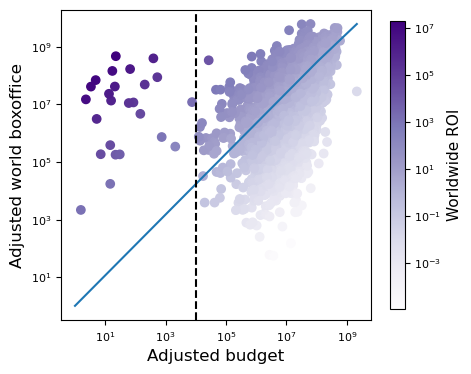

In [16]:
# Check for outliers in ROI
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

im = axs.scatter(clean_data['adjusted_budget'], clean_data['adjusted_worldwide_boxoffice'], 
            c = clean_data['wroi'], cmap = "Purples", norm = mpl.colors.LogNorm())
axs.plot(np.linspace(1, np.amax(clean_data['adjusted_budget']), 20),
         np.linspace(1, np.amax(clean_data['adjusted_worldwide_boxoffice']), 20))
axs.axvline(x = 10000, color = 'k', linestyle = "--")
plt.semilogx()
plt.semilogy()

axs.minorticks_off()
axs.set_box_aspect(1)
axs.tick_params(axis='both', which='major', labelsize=8)

cb = fig.colorbar(im, ax=axs, orientation='vertical', shrink = 0.75, pad = 0.05)
cb.set_label("Worldwide ROI", fontsize = 11)
cb.ax.tick_params(labelsize=8)
axs.set_xlabel("Adjusted budget", fontsize = 12)
axs.set_ylabel("Adjusted world boxoffice", fontsize = 12)

This motivates setting the budget cutoff at $10000

Text(0, 0.5, 'Adjusted world boxoffice')

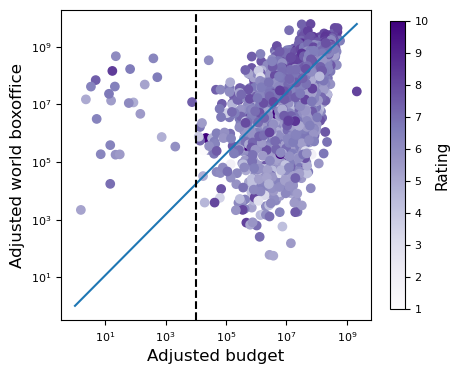

In [17]:
# Check for outliers in ratings
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

im = axs.scatter(clean_data['adjusted_budget'], clean_data['adjusted_worldwide_boxoffice'], 
            c = clean_data['rating'], cmap = "Purples", norm = mpl.colors.Normalize())
axs.plot(np.linspace(1, np.amax(clean_data['adjusted_budget']), 20),
         np.linspace(1, np.amax(clean_data['adjusted_worldwide_boxoffice']), 20))
axs.axvline(x = 10000, color = 'k', linestyle = "--")
plt.semilogx()
plt.semilogy()

axs.minorticks_off()
axs.set_box_aspect(1)
axs.tick_params(axis='both', which='major', labelsize=8)

cb = fig.colorbar(im, ax=axs, orientation='vertical', shrink = 0.75, pad = 0.05)
cb.set_label("Rating", fontsize = 11)
cb.ax.tick_params(labelsize=8)
axs.set_xlabel("Adjusted budget", fontsize = 12)
axs.set_ylabel("Adjusted world boxoffice", fontsize = 12)

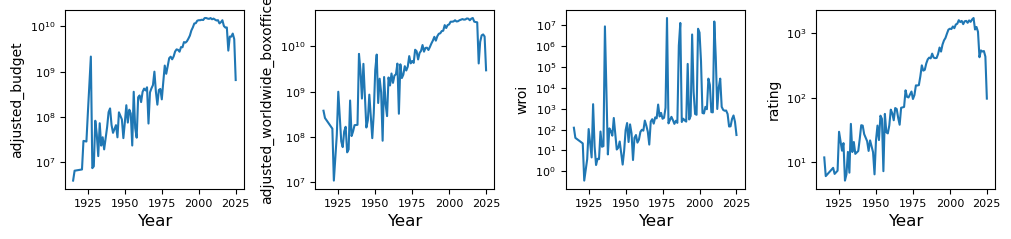

In [18]:
# Inspect distribution of observables
fig, axs = plt.subplots(1, 4, figsize=(3*4, 3), sharex=False, sharey=False)

for i, var in enumerate(['adjusted_budget', 'adjusted_worldwide_boxoffice', 'wroi', 'rating']):
    input_data = clean_data[['year'] + [var]].groupby(['year'], as_index = False).sum()
    axs[i].plot(input_data['year'], input_data[var]);
    axs[i].semilogy()
    axs[i].minorticks_off()
    axs[i].yaxis.set_tick_params(labelbottom=True)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel(var, fontsize = 10)
    axs[i].set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

       year  title
0    1915.0      2
1    1921.0      1
2    1922.0      1
3    1924.0      1
4    1925.0      4
..      ...    ...
96   2021.0     67
97   2022.0     67
98   2023.0     72
99   2024.0     58
100  2025.0     13

[101 rows x 2 columns]


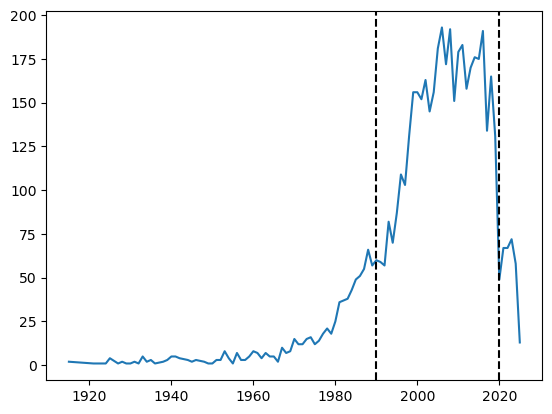

In [19]:
input_data = clean_data.loc[(clean_data.adjusted_budget >= 10000)*(clean_data.is_production_usa > 0)].groupby(['year'], as_index = False).count()
plt.plot(input_data.year, input_data.title)
plt.axvline(x = 1990, color = 'k', linestyle = "--")
plt.axvline(x = 2020, color = 'k', linestyle = "--")
print(input_data[['year', 'title']])

### Runtime Outliers

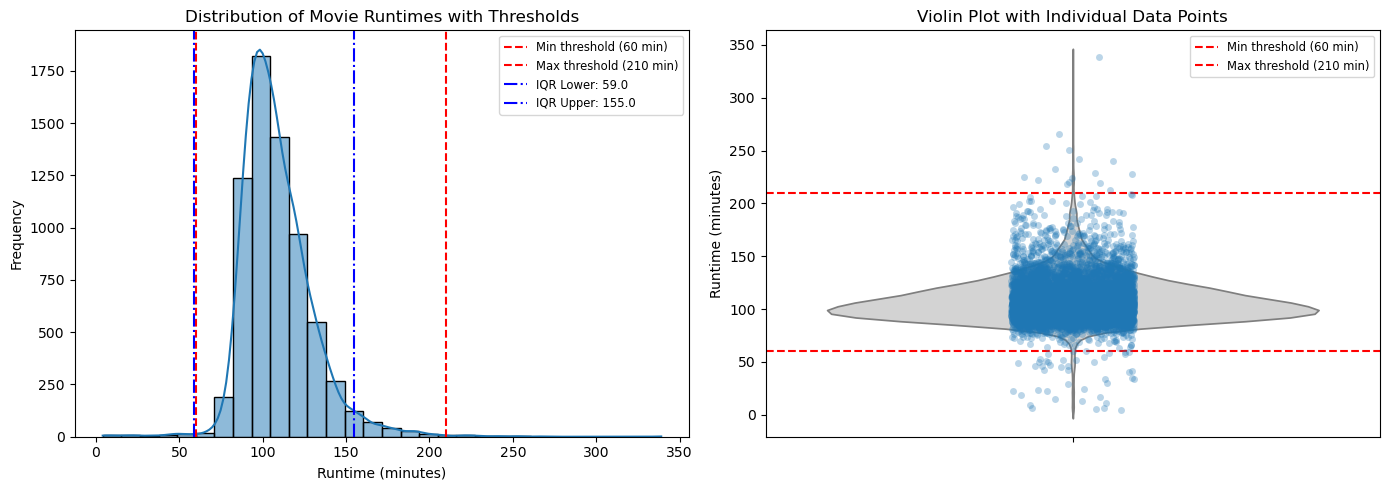

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(clean_data['runtime'], bins=30, kde=True, ax=axs[0])
axs[0].axvline(x=60, color='r', linestyle='--', label='Min threshold (60 min)')
axs[0].axvline(x=210, color='r', linestyle='--', label='Max threshold (210 min)')

Q1 = clean_data['runtime'].quantile(0.25)
Q3 = clean_data['runtime'].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR
axs[0].axvline(x=lower_bound_iqr, color='blue', linestyle='-.', label=f'IQR Lower: {lower_bound_iqr:.1f}')
axs[0].axvline(x=upper_bound_iqr, color='blue', linestyle='-.', label=f'IQR Upper: {upper_bound_iqr:.1f}')

axs[0].set_xlabel('Runtime (minutes)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Movie Runtimes with Thresholds')
axs[0].legend(fontsize='small')

sns.violinplot(y=clean_data['runtime'], ax=axs[1], inner=None, color='lightgray')
sns.stripplot(y=clean_data['runtime'], ax=axs[1], alpha=0.3, jitter=True)
axs[1].axhline(y=60, color='r', linestyle='--', label='Min threshold (60 min)')
axs[1].axhline(y=210, color='r', linestyle='--', label='Max threshold (210 min)')
axs[1].set_ylabel('Runtime (minutes)')
axs[1].set_title('Violin Plot with Individual Data Points')
axs[1].legend(fontsize='small')


plt.tight_layout()
plt.show()

In [21]:
input_data = clean_data.loc[(clean_data.adjusted_budget >= 10000)*(clean_data.is_production_usa > 0)]
input_data.loc[:, 'count_appear'] = input_data.apply(appearances_before_year, args = (["production_company_2", "top_production_companies", 'wroi', 5, input_data]), axis = 1)

/var/folders/_q/50__mrnj2zv6hb8crhk3q46m0000gn/T/ipykernel_97425/869248481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:, 'count_appear'] = input_data.apply(appearances_before_year, args = (["production_company_2", "top_production_companies", 'wroi', 5, input_data]), axis = 1)


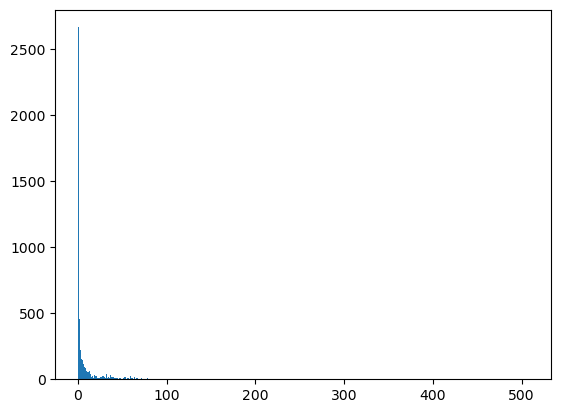

In [22]:
plt.hist(input_data.loc[:, 'count_appear'],
         bins=np.arange(0, np.amax(input_data['count_appear'])));

In [23]:
input_data[['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi', 'top_production_companies', 'production_company_1','production_company_2','count_appear']].sort_values(by ="count_appear", ascending=False)

,title,budget,worldwide_boxoffice,year,release_date,wroi,top_production_companies,production_company_1,production_company_2,count_appear
301,Amigo,1500000.0,184705.0,2011.0,2011-08-19,0.123137,"[""Anarchist's Convention Films"", 'Pictures']",Anarchist's Convention Films,Pictures,509.0
675,Beyond the Lights,7000000.0,14618727.0,2014.0,2014-09-10,2.088390,"['Black Entertainment Television', 'Relativity...",Black Entertainment Television,Relativity Media,80.0
5734,The November Man,15000000.0,34820335.0,2014.0,2014-08-27,2.321356,"['SPD Films', 'Relativity Media', 'Irish Dream...",SPD Films,Relativity Media,80.0
4202,Rocky Balboa,24000000.0,156229050.0,2006.0,2006-12-20,6.509544,"['Metro-Goldwyn-Mayer', 'Columbia Pictures', '...",Metro-Goldwyn-Mayer,Columbia Pictures,78.0
5799,The Pink Panther,80000000.0,158926474.0,2006.0,2006-02-10,1.986581,"['Metro-Goldwyn-Mayer', 'Columbia Pictures', '...",Metro-Goldwyn-Mayer,Columbia Pictures,78.0
...,...,...,...,...,...,...,...,...,...,...
3281,Message in a Bottle,30000000.0,52880016.0,1999.0,1999-02-12,1.762667,"['Warner Bros. Pictures', 'Bel Air Entertainme...",Warner Bros. Pictures,Bel Air Entertainment,0.0
3282,Metallica Through the Never,18000000.0,9082906.0,2013.0,2013-09-27,0.504606,"['Exclusive Media', 'Picturehouse Entertainment']",Exclusive Media,Picturehouse Entertainment,0.0
3284,Meteor,16000000.0,8400000.0,1979.0,1979-10-19,0.525000,"['American International Pictures', 'Meteor Jo...",American International Pictures,Meteor Joint Venture,0.0
3289,Metropolitan,430000.0,2938000.0,1990.0,1990-08-03,6.832558,"['Westerly Films', 'Allagash Films', 'New Line...",Westerly Films,Allagash Films,0.0


In [24]:
# Filter dataset
for_analysis = clean_data.loc[(clean_data.adjusted_budget >= 10000)*(clean_data.year >= 1990)*(clean_data.year <= 2020)*(clean_data.is_production_usa > 0)*(clean_data.runtime >= 60) *  (clean_data.runtime <= 210)].copy()
for_analysis.describe().T

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
budget,4272.0,3.907858e+07,4.486176e+07,6000.000000,1.000000e+07,2.500000e+07,5.000000e+07,4.000000e+08
worldwide_boxoffice,4272.0,1.130256e+08,1.960773e+08,30.000000,1.028531e+07,4.247993e+07,1.266739e+08,2.748243e+09
domestic_boxoffice,4272.0,5.113450e+07,7.453157e+07,0.000000,6.569525e+06,2.641999e+07,6.342375e+07,9.366622e+08
year,4272.0,2.006604e+03,7.822660e+00,1990.000000,2.001000e+03,2.007000e+03,2.013000e+03,2.020000e+03
rating,4272.0,6.355186e+00,8.273185e-01,1.900000,5.892000e+00,6.400000e+00,6.900000e+00,1.000000e+01
...,...,...,...,...,...,...,...,...
wavg_risk_ratio,4272.0,5.972727e+00,7.134405e+00,0.000000,8.999541e-01,1.485313e+00,1.438115e+01,2.007549e+01
max_risk_ratio,4272.0,6.712512e+00,7.643216e+00,0.505561,1.000000e+00,1.740681e+00,1.587291e+01,2.007549e+01
production_efficiency_score,4272.0,1.297399e+00,6.607314e-01,0.076971,7.668655e-01,1.076795e+00,1.931408e+00,4.691882e+00
production_efficiency_score_log,4272.0,7.917036e-01,2.814759e-01,0.074152,5.692070e-01,7.308260e-01,1.075483e+00,1.739041e+00


In [25]:
# Create variables to store rolling 5-year average ROI for each category
ensemble_pairs = [[["actor_id_1", "actor_id_2", "actor_id_3"], "top_cast_id", 'wroi'],
                  [["genre_name_1", "genre_name_2", "genre_name_3"], "genres_list", 'wroi'],
                  [["production_company_1", "production_company_2", "production_company_3"], "top_production_companies", 'wroi'],
                  [["actor_id_1", "actor_id_2", "actor_id_3"], "top_cast_id", 'rating'],
                  [["genre_name_1", "genre_name_2", "genre_name_3"], "genres_list", 'rating'],
                  [["production_company_1", "production_company_2", "production_company_3"], "top_production_companies", 'rating']
                 ]

# Compute values for individual entities
for p in ensemble_pairs:
    for_analysis.loc[:, 'avg_'+p[2]+'_'+p[1]] = for_analysis.apply(role_value_before_year, args = ([p[0], p[1], p[2], 5, for_analysis]), axis = 1)

In [26]:
# Create variables to store rolling 5-year average ROI for each category
indiv_pairs = [['director_id_1', 'top_director_id', 'wroi'],
         ["actor_id_1", "top_cast_id", 'wroi'],["actor_id_2", "top_cast_id", 'wroi'], ["actor_id_3", "top_cast_id", 'wroi'],
         ["genre_name_1", "genres_list", 'wroi'],["genre_name_2", "genres_list", 'wroi'], ["genre_name_3", "genres_list", 'wroi'],
         ["production_company_1", "top_production_companies", 'wroi'],["production_company_2", "top_production_companies", 'wroi'], ["production_company_3", "top_production_companies", 'wroi'],
         ['director_id_1', 'top_director_id', 'rating'],
         ["actor_id_1", "top_cast_id", 'rating'],["actor_id_2", "top_cast_id", 'rating'], ["actor_id_3", "top_cast_id", 'rating'],
         ["genre_name_1", "genres_list", 'rating'],["genre_name_2", "genres_list", 'rating'], ["genre_name_3", "genres_list", 'rating'],
         ["production_company_1", "top_production_companies", 'rating'],["production_company_2", "top_production_companies", 'rating'], ["production_company_3", "top_production_companies", 'rating']]

# Compute values for individual entities
for p in indiv_pairs:
    for_analysis.loc[:, 'avg_'+p[2]+'_'+p[0]] = for_analysis.apply(indiv_value_before_year, args = ([p[0], p[1], p[2], 10 if 'director' in p[0] else 5, for_analysis]), axis = 1)

# Compute value based on similarity score
for_analysis.loc[:, 'avg_wroi_similar_overview'] = for_analysis.apply(get_movie_similarity, 
                                                 args = (['movie_overview', 'wroi', 10, for_analysis]), axis = 1)

In [27]:
for_analysis.describe().T

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
budget,4272.0,3.907858e+07,4.486176e+07,6000.000000,1.000000e+07,2.500000e+07,5.000000e+07,4.000000e+08
worldwide_boxoffice,4272.0,1.130256e+08,1.960773e+08,30.000000,1.028531e+07,4.247993e+07,1.266739e+08,2.748243e+09
domestic_boxoffice,4272.0,5.113450e+07,7.453157e+07,0.000000,6.569525e+06,2.641999e+07,6.342375e+07,9.366622e+08
year,4272.0,2.006604e+03,7.822660e+00,1990.000000,2.001000e+03,2.007000e+03,2.013000e+03,2.020000e+03
rating,4272.0,6.355186e+00,8.273185e-01,1.900000,5.892000e+00,6.400000e+00,6.900000e+00,1.000000e+01
...,...,...,...,...,...,...,...,...
avg_rating_genre_name_3,4272.0,9.763622e-01,9.169916e-01,0.000000,0.000000e+00,1.792494e+00,1.833849e+00,2.083255e+00
avg_rating_production_company_1,4272.0,1.134065e+00,8.991517e-01,0.000000,0.000000e+00,1.800838e+00,1.856194e+00,2.136176e+00
avg_rating_production_company_2,4272.0,9.540839e-01,9.264655e-01,0.000000,0.000000e+00,1.704373e+00,1.850829e+00,2.140066e+00
avg_rating_production_company_3,4272.0,6.184103e-01,8.732607e-01,0.000000,0.000000e+00,0.000000e+00,1.807179e+00,2.140537e+00


In [28]:
for_analysis.sort_values(by ="wroi", ascending=False)[['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi', 'avg_wroi_similar_overview']]

,title,budget,worldwide_boxoffice,year,release_date,wroi,avg_wroi_similar_overview
3776,Paranormal Activity,15000.0,193355800.0,2007.0,2007-09-14,12890.386667,0.687206
5287,The Gallows,100000.0,42964410.0,2015.0,2015-07-09,429.644100,0.381718
5011,The Blair Witch Project,600000.0,248300000.0,1999.0,1999-07-14,413.833333,0.648018
4777,Super Size Me,65000.0,20645757.0,2004.0,2004-01-17,317.627031,-0.251750
5059,The Brothers McMullen,50000.0,10426506.0,1995.0,1995-08-09,208.530120,0.229620
...,...,...,...,...,...,...,...
869,Broken Horses,15000000.0,3471.0,2015.0,2015-04-10,0.000231,0.397442
1870,Food Chains,913000.0,176.0,2014.0,2014-11-21,0.000193,0.386470
5357,The Grimm Brothers' Snow White,26000000.0,5000.0,1997.0,1997-08-24,0.000192,-0.538447
6091,The Walking Deceased,2000000.0,43.0,2015.0,2015-03-20,0.000022,-0.223459


### Export dataset

In [29]:
with open('processed_data/train_build.pkl', 'wb') as f:
    pickle.dump(for_analysis.loc[for_analysis.year <= 2015], f)

with open('processed_data/test_build.pkl', 'wb') as f:
    pickle.dump(for_analysis.loc[for_analysis.year > 2015], f)